In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [ ]:
base_image_path = keras.utils.get_file('paris.jpg', 'https://i.imgur.com/F28w3Ac.jpg')
style_reference_image_path = keras.utils.get_file('starry_night.jpg', 'https://i.imgur.com/9ooB60I.jpg')
result_prefix = 'paris_generated'
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height) 

942080/935806 [==============================] - 1s 1us/step


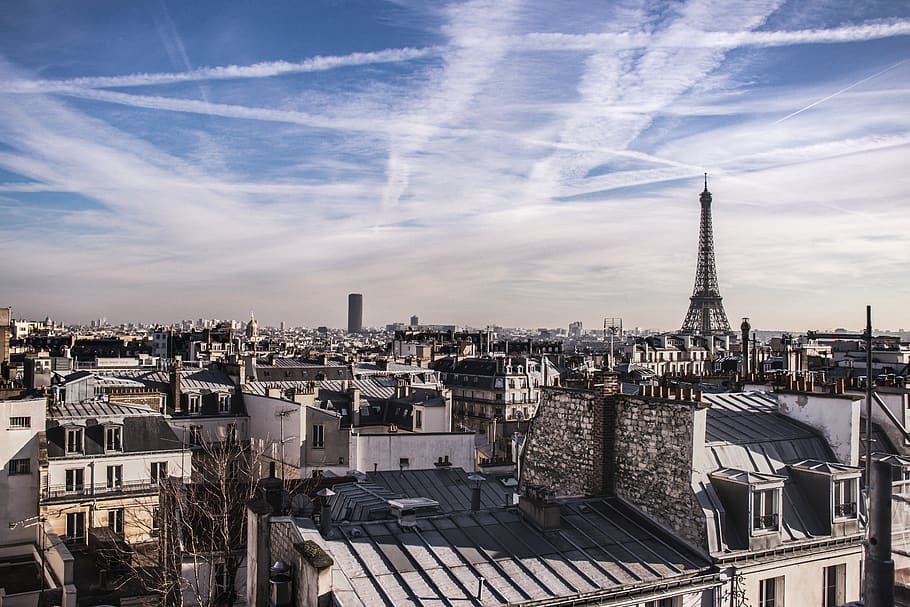

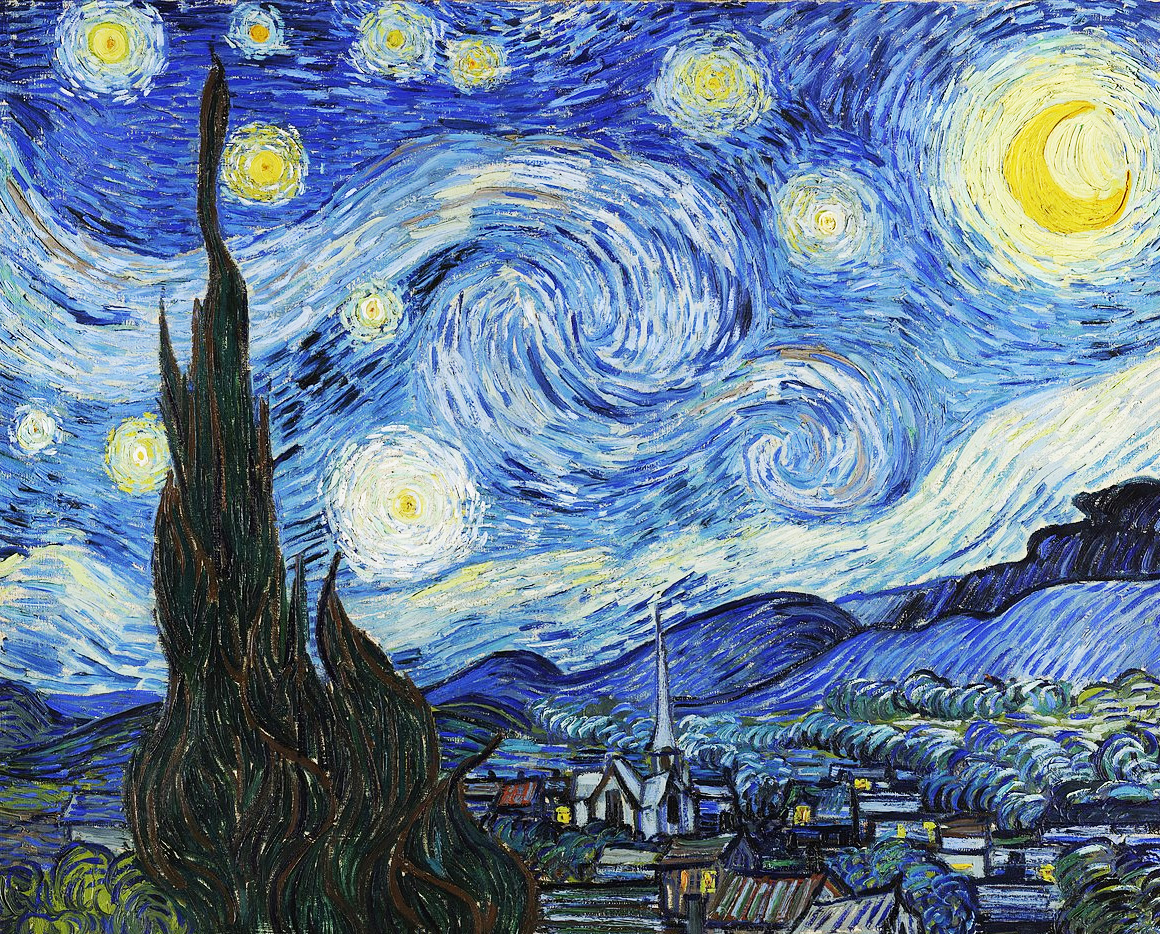

In [ ]:
from IPython.display import Image, display
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_image(x):
  x = x.reshape((img_nrows, img_ncols, 3))
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
  a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
  b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
style_layer_names = [
          'block1_conv1',
          'block2_conv1',
          'block3_conv1',
          'block4_conv1',
          'block5_conv1',
]
content_layer_name = 'block5_conv2'

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
  features = feature_extractor(input_tensor)
  loss = tf.zeros(shape=())
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features, combination_features)
  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * sl
  loss += total_variation_weight * total_variation_loss(combination_image)
  return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
))
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))
iterations = 4000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print(f'Iteration {i}: loss={loss}')
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + f'_at_iteration_{i}.png'
    keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=11017.6806640625
Iteration 200: loss=8513.7470703125
Iteration 300: loss=7571.2998046875
Iteration 400: loss=7063.5751953125
Iteration 500: loss=6735.56591796875
Iteration 600: loss=6501.294921875
Iteration 700: loss=6322.9111328125
Iteration 800: loss=6181.240234375
Iteration 900: loss=6065.2177734375
Iteration 1000: loss=5967.73779296875
Iteration 1100: loss=5884.7138671875
Iteration 1200: loss=5813.12451171875
Iteration 1300: loss=5750.89208984375
Iteration 1400: loss=5696.31298828125
Iteration 1500: loss=5647.96337890625
Iteration 1600: loss=5604.89453125
Iteration 1700: loss=5566.197265625
Iteration 1800: loss=5531.259765625
Iteration 1900: loss=5499.6923828125
Iteration 2000: loss=5471.04736328125
Iteration 2100: loss=5444.94970703125
Iteration 2200: loss=5421.04638671875
Iteration 2300: loss=5399.1103515625
Iteration 2400: loss=5378.92041015625
Iteration 2500: loss=5360.267578125
Iteration 2600: loss=5343.0244140625
Iteration 2700: loss=5327.05615234375
Itera

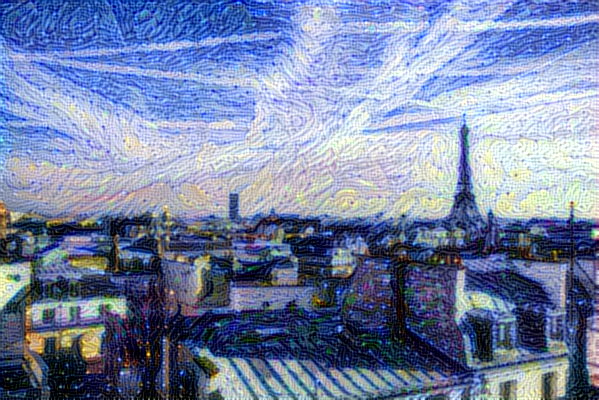

In [ ]:
display(Image(result_prefix + '_at_iteration_4000.png'))